## PGGAN

##### => **local minima 해결**
generator와 discriminator를 점진적으로 키우자
→ 속도 향상,안정화

**achieve a record inception score of 8.80 in unsupervised CIFAR10**

- **Autoregressive models (PixelCNN)** : sharp images, slow to evaluate, no latent space
- **VAE** : easy and fast to train, blurry images,
- **GANs** : sharp images, low resolution, limited variation, unstabble training

기존 GAN은 모든 scale에 대해 동시 학습.

PGGAN은 처음에 대략 이미지 구성 파악한 후 단계적으로 세부적인 디테일을 봄.

low-resolution부터 본다는게 핵심. 점진적으로 resolution 증가. adding layers를 통해.

4*4 저해상도로 시작해서 1024*1024 고해상도로 높아짐

4*4로 대략적인 윤곽을 쉽게 학습하고, 8*8 레이어 추가해서 8*8공간에 대해 채워넣을 값들을 예측한 후 점진적으로 해상도 늘려가면서 학습.

layer 추가되면 존재하고 있던 layers(작은 resolution layers나 well-trained layers)에서 새로운 layer로 fade in (점점 똑똑해짐. 점점 더 크게 함)

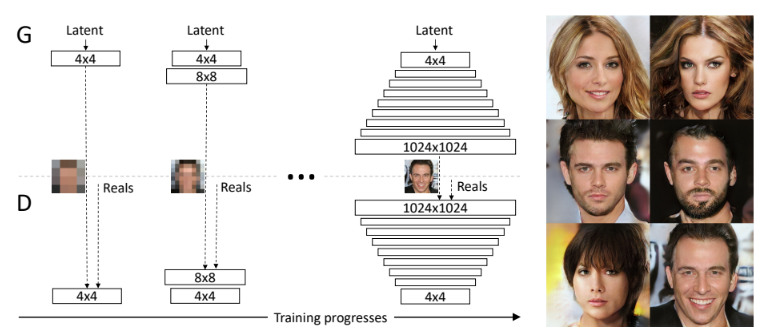

In [1]:
from PIL import Image
image = Image.open("./1.png")
image

비교 대상이 되는 원본 데이터가 D의 입력층에 맞추어 해상도를 줄이거나 늘려서 loss값을 구해야 함. G가 만든 저해상 이미지가 D에게 진짜와 같다고 인정받으면, G와 D의 레이어를 하나씩 더 추가시켜 나가는 것으로, 학습방향을 정할 수 있음.

**Increasing Variation using Minibatch standard Deviation**

이렇게 new layer를 점차 넣는 과정은 well-trained layers에 sudden shock주는 것 방지.

mode collapsing(일부의 데이터 분포만을 사용하고자 하는 현상)의 해결방안으로 **minibatch discrimination.**

이 방법은 보통 discriminator 맨 뒤에 추가

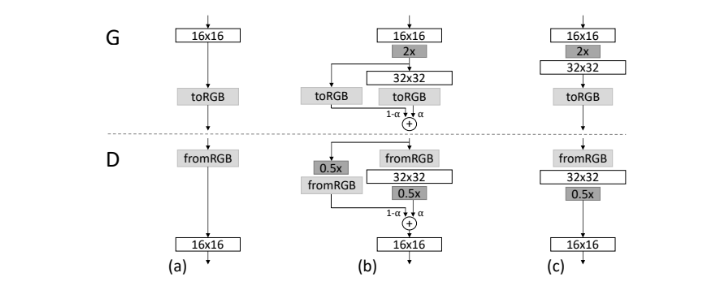

In [2]:
image = Image.open("./2.png")
image

### Smooth Fade in
먼저 16x16 해상도로 RGB 이미지를 만들었다고 하자.

곧바로 그 2배인 32x32 해상도를 학습시킬 수 있으면 좋겠지만, 이렇게 되면 아직 학습이 전혀 안된 32x32 레이어의 간섭으로, 기껏 잘 학습된 저해상도 레이어까지 영향을 미칠 수 있음

그렇기에 스무스하게 레이어를 끼워넣는 방식이 필요한데, 이전 학습시킨 레이어의 출력 결과물을 사용하는 것임

b로 갈때, 그냥 32x32레이어만 끼워넣는 것이 아니라, 16x16으로 만들어낸 이미지를 2배로 upsampling. 그러니까, 저해상도 이미지의 스케일만 늘려서, 대략적인 형태를 지닌 이미지를 만들어내는 것

그리고 32x32에서 만들어낸 이미지 역시 존재할텐데, 잘 학습된 저해상 이미지와, 이 새로운 이미지를 서로 합침

그냥 합치는게 아니라, 각 픽셀 값에 1~0 사이의 비율을 나타내는 (알파)를 곱하고, 저해상도 픽셀에는 그 나머지 비율을 뜻하는 (1-알파)를 곱해줘서 서로 더해주면, 저해상도의 큰 그림과, 앞으로 학습시킬 고해상도의 디테일이 합쳐짐

D에서는 역시나 학습 안된 32x32레이어와 더불어, 저해상도로 학습된 16x16을 위해 위와 같은 방식으로 학습을 진행 (알파는 0에서 1로 점차적으로 증가합니다. 즉, 이전 레이어의 영향력이 갈수록 줄어드는 것.)

그렇게 하여 기존의 저해상도 레이어에서 학습된 방향을 일그러뜨리지 않고, 새로 추가된 레이어를 학습시킬수 있다.

학습이 일정수준 이상이 되었으면 이전 레이어의 보조를 빼고, 그대로 동작을 시키며 파인튜닝

### 구현
1. 이미지 데이터셋 준비
2. 이미지 데이터셋 해상도 변경(16,32,64,128 ... 1024)
3. 16x16의 GAN을 작성후 학습.
4. 학습이 완료되면 32x32레이어를 추가.

이때부턴 기존 GAN과 다른 구조가 하나 생겨나는데,

바로 이전 레이어의 결과물을 출력하고, 그것에 비율을 매겨서, 이전 레이어 결과물 비율 1-a와, 이번 레이어 결과물 비율 a를 통해 점차 a가 증가하며 학습을 하는 것입니다.

a가 1이 되어 이번 레이어에게 출력에 대한 최종 영향력이 완전히 넘어가고, 학습이 잘 이뤄지면, 다음 레이어를 또 추가.

1. 원하는 해상도가 될때까지 위를 반복.